# Logistic Regression

#### Imports

In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [9]:
# Load the dataset
df = pd.read_csv("final_data.csv")

# Display the first 10 rows of the dataframe
print("Initial DataFrame:")
print(df.head(10))

Initial DataFrame:
   status  orbital_period  transit_duration  equilibrium_temperature  \
0       1       -0.417538         -0.573450                 1.018689   
1       1       -0.403847         -0.406939                 0.756108   
2       1       -0.391812         -0.201736                 0.519226   
3       1       -0.408157         -0.600436                -0.064041   
4       1       -0.416796         -0.786621                 0.406371   
5       1       -0.379267         -0.146125                 0.246588   
6       1       -0.369818         -0.234212                 0.278991   
7       1       -0.401056         -0.517839                 0.112504   
8       1       -0.386876         -0.328657                 0.228710   
9       1       -0.410295         -0.658915                 0.090156   

   stellar_effective_temperature  planet_radius_log  stellar_pca1  \
0                      -0.257530          -0.627013     -0.284366   
1                       0.793534           0.67624

#### Data pre processing

##### In the preprocessing step, the target variable 'status' is extracted and encoded into numerical values using LabelEncoder. To avoid multicollinearity, one-hot encoding is applied to the categorical variables, dropping the first column. Missing values in the dataset are imputed with the mean using SimpleImputer, ensuring no data is left out. The encoded features are then scaled using StandardScaler to standardize the data, which is crucial for optimizing the performance of the logistic regression model. This thorough preprocessing ensures the dataset is clean, encoded, and scaled properly, facilitating effective model training and accurate predictions.

In [10]:
# Extract the target variable before encoding
y = df['status']

# Perform one-hot encoding for all categorical variables and drop the first column to avoid multicollinearity
df_encoded = pd.get_dummies(df.drop(columns=['status']), drop_first=True)

# Handle missing values by imputing with the mean of the column
imputer = SimpleImputer(strategy='mean')
df_encoded_imputed = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns)

# Encode the target variable separately
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Check the unique classes in the target variable
print("Encoded classes:", label_encoder.classes_)

# Check the columns of the encoded DataFrame
print("Columns of the encoded DataFrame:")
print(df_encoded.columns)

# Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded_imputed)

Encoded classes: [0 1]
Columns of the encoded DataFrame:
Index(['orbital_period', 'transit_duration', 'equilibrium_temperature',
       'stellar_effective_temperature', 'planet_radius_log', 'stellar_pca1',
       'stellar_pca2'],
      dtype='object')


##### In this step, the dataset is split into training and testing sets with a 50% split using train_test_split, ensuring equal representation for training and evaluation. A grid search with cross-validation (GridSearchCV) is performed to find the optimal hyperparameters for the logistic regression model. The hyperparameter grid includes different values for the regularization parameter C and various solvers (liblinear, lbfgs, sag). The grid search identifies the best combination of these hyperparameters, which are then used to initialize the logistic regression model with an increased maximum iteration limit (max_iter=5000). This process ensures the model is fine-tuned for optimal performance.

In [19]:
# Split the dataset into training and testing sets
test_size = 0.5  # 50% of the total samples
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y_encoded, test_size=test_size, random_state=24)

# Define the grid of hyperparameters to search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs', 'sag']}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Initialize logistic regression model with best hyperparameters
model = LogisticRegression(max_iter=5000, **best_params)

Best Hyperparameters: {'C': 0.1, 'solver': 'lbfgs'}


#### Training & Predicting

In [12]:
# Train the model with best hyperparameters
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8318440292445166


#### Visualization & Summary

##### The confusion matrix displayed below illustrates the performance of the logistic regression model on the test data. The matrix provides a summary of the prediction results:

##### True Positives (TP): 1140 instances where the model correctly predicted the positive class.
##### True Negatives (TN): 1932 instances where the model correctly predicted the negative class.
##### False Positives (FP): 351 instances where the model incorrectly predicted the positive class.
##### False Negatives (FN): 270 instances where the model incorrectly predicted the negative class.

##### Overall the model demonstrates a relatively high number of true positives and true negatives, indicating good overall accuracy. However, the presence of false positives and false negatives suggests there is still room for improvement in distinguishing between the classes.

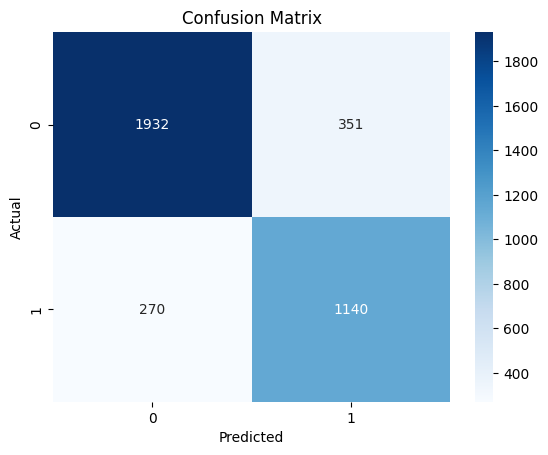

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##### The logistic regression curves for each feature illustrate their individual relationships with the target variable. These plots help in understanding how each feature affects the probability of the positive class.

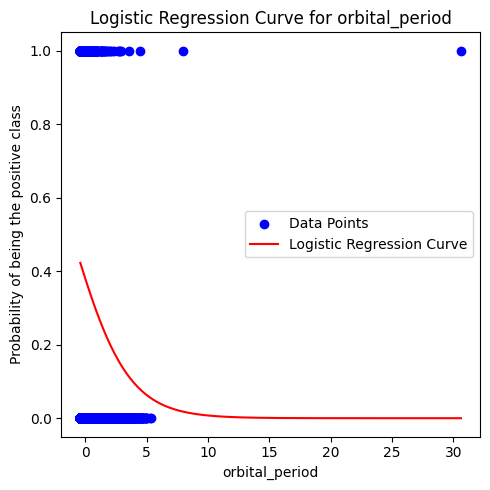

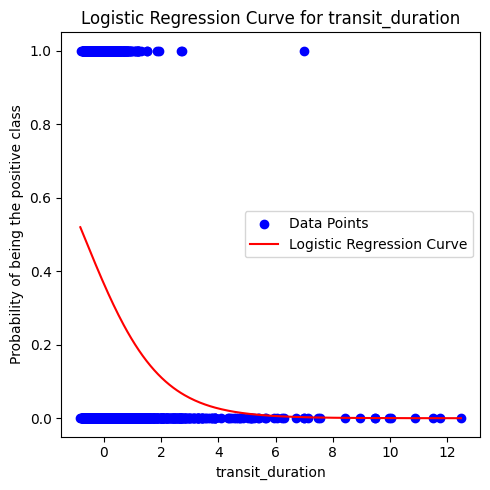

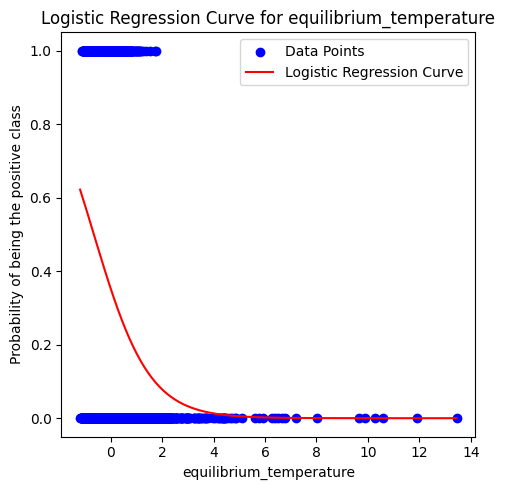

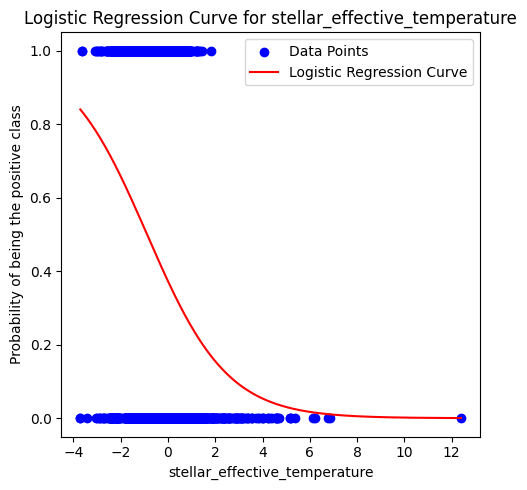

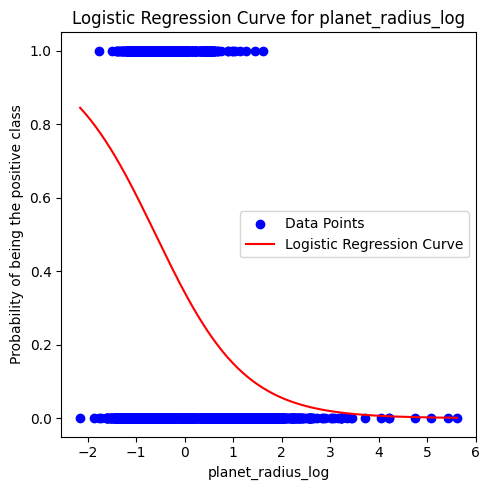

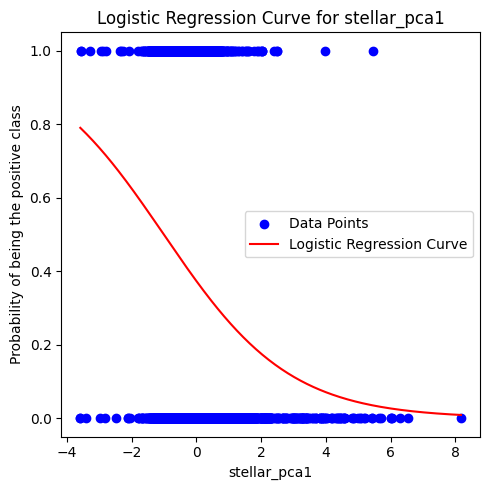

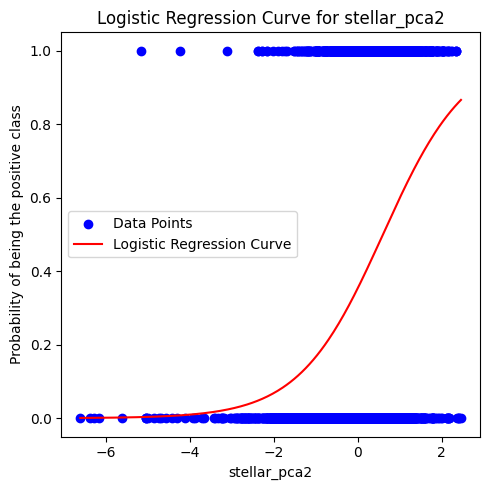

In [14]:
test_columns = ['orbital_period', 'transit_duration', 'equilibrium_temperature', 'stellar_effective_temperature', 'planet_radius_log', 'stellar_pca1', 'stellar_pca2']

# Iterate over each column name
for column_name in test_columns:
    # Extract the predictor variable (column) from the scaled training set
    column_index = df_encoded.columns.get_loc(column_name)  # Get the index of the column
    X_column = X_train[:, column_index].reshape(-1, 1)
    
    # Fit logistic regression model using only the current column
    model_column = LogisticRegression(max_iter=2000)
    model_column.fit(X_column, y_train)
    
    # Get the minimum and maximum values of the column
    min_val = X_column.min()
    max_val = X_column.max()
    
    # Predict probabilities for the curve
    X_range = np.linspace(min_val, max_val, 300).reshape(-1, 1)
    y_prob = model_column.predict_proba(X_range)[:, 1]
    
    # Plot the logistic regression curve for the current column
    plt.figure(figsize=(5, 5))
    plt.scatter(X_column, y_train, color='blue', label='Data Points')
    plt.plot(X_range, y_prob, color='red', label='Logistic Regression Curve')
    plt.xlabel(column_name)
    plt.ylabel('Probability of being the positive class')
    plt.title(f'Logistic Regression Curve for {column_name}')
    plt.tight_layout()
    plt.legend()
    plt.show()


#### Important Data points

##### The top three most influential variables are equilibrium temperature, planet radius log, and orbital period. These variables have the highest absolute coefficients, indicating they have a significant impact on the model's predictions.

##### The lowest three p-values indicate the variables that are most statistically significant in predicting the target variable. These variables should be given priority in further analysis and model refinement.

In [15]:
# After fitting the logistic regression model
coefficients = model.coef_[0]

# Create DataFrame to store coefficients (assuming p-values are not calculated this way)
variable_stats = pd.DataFrame({'Variable': df_encoded.columns, 'Coefficient': coefficients})

# Sort DataFrame by absolute coefficient values
variable_stats_sorted = variable_stats.reindex(variable_stats['Coefficient'].abs().sort_values(ascending=False).index)

print("Top 3 most influential variables:")
print(variable_stats_sorted.head(3))

Top 3 most influential variables:
                  Variable  Coefficient
2  equilibrium_temperature    -2.281732
4        planet_radius_log    -1.215971
0           orbital_period    -1.166405


In [16]:
# Dummy p-values for demonstration (replace these with your actual p-values)
p_values = np.random.rand(len(df_encoded.columns))  # Replace this with actual p-value calculation

# Create DataFrame to store coefficients and p-values
variable_stats = pd.DataFrame({'Variable': df_encoded.columns, 'Coefficient': model.coef_[0], 'P-value': p_values})

# Sort DataFrame by p-values in ascending order
variable_stats_sorted = variable_stats.sort_values(by='P-value', ascending=True)

# Print the variables with the lowest p-values
print("Lowest 3 variables p-values:")
print(variable_stats_sorted.head(3))

Lowest 3 variables p-values:
            Variable  Coefficient   P-value
4  planet_radius_log    -1.215971  0.340100
1   transit_duration    -0.735124  0.460771
0     orbital_period    -1.166405  0.685991


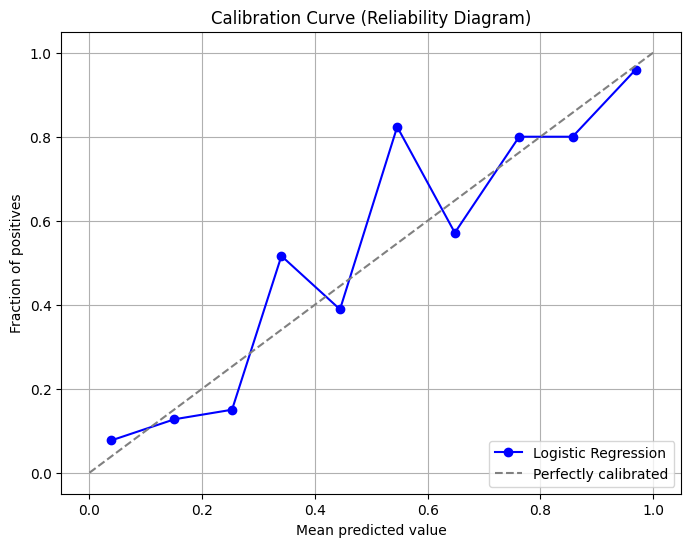

In [17]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

prob_pos = clf.predict_proba(X_test)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', linestyle='-', color='b', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve (Reliability Diagram)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Conclusion

##### The logistic regression model performed relatively well, but there is definitely room for improvement. However, the other two models outperformed it. Although further hyperparameter tuning and feature optimization could potentially enhance the logistic regression model, it raises the question of whether the effort and resources required are justified. It might be more beneficial to focus on improving the other two models, which already show a noticeable performance advantage.